In [1]:
import numpy as np
import math
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

#from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.layers import *

from keras.applications import MobileNetV2
from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json

from keras.models import load_model

In [2]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

grid_size = [19, 19]
grid_y_axis = 19  # each image is to be segmented to 17 x 17 grid
grid_x_axis = 19  # # each image is to be segmented to 17 x 17 grid

grid_stride = target_w / grid_x_axis  # grid cell width
grid_stride = target_h / grid_y_axis  # grid cell height

channels = 3
num_anchors = 3
class_num = 1     ## item
info = 5 + class_num    # pc, x, y, h, w, and class probabilities

categories = ['item'] # details of classes

In [3]:
# Making a list of image path

inv_directory = '/home/scar3crow/Downloads/drg_all'   
                                                        
inv_new_image = ['/home/scar3crow/Downloads/drg_all/{}'.format(i) for i in os.listdir(inv_directory)] # making the list
inv_new_image.sort() # Sorting the list

num_images = len(inv_new_image)

print('Number of images = ', num_images)


Number of images =  123


In [4]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_new = pd.DataFrame()

for i in range(len(inv_new_image)):
    image = cv2.imread(inv_new_image[i]) ## Loading image
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(inv_new_image[i])
        
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_new.insert(loc=0, column='image_serial', value=image_num)
df_new.insert(loc=1, column='rows', value=row_values)
df_new.insert(loc=2, column='columns', value=col_values)

df_new.tail(3)

image_serial  rows  columns
120  /home/scar3crow/Downloads/drg_all/97.jpg  2479     3508
121  /home/scar3crow/Downloads/drg_all/98.jpg  2479     3508
122  /home/scar3crow/Downloads/drg_all/99.jpg  2479     3508

In [5]:
# Loading output of VGG Image Annotation tool and create a dataframe

r_new_data = pd.DataFrame()

r_new_data_1 = pd.read_csv('/home/scar3crow/Downloads/via_drg_1.csv')
r_new_data_2 = pd.read_csv('/home/scar3crow/Downloads/via_drg_2.csv')
r_new_data_3 = pd.read_csv('/home/scar3crow/Downloads/via_drg_3.csv')
r_new_data_4 = pd.read_csv('/home/scar3crow/Downloads/via_drg_4.csv')


r_new_data = pd.concat([r_new_data_1, r_new_data_2, r_new_data_3, r_new_data_4], axis = 0, ignore_index = True)

num_obj = r_new_data['region_count'][0] # number of objects in each photo
r_new_data.drop(r_new_data.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data = r_new_data[(r_new_data['#filename'] != '33.jpg') & (r_new_data['#filename'] != '20.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '74.jpg') & (r_new_data['#filename'] != '42.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '96.jpg') & (r_new_data['#filename'] != '28.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '47.jpg') & (r_new_data['#filename'] != '122.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '63.jpg') & (r_new_data['#filename'] != '97.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '56.jpg') & (r_new_data['#filename'] != '38.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '36.jpg')].reset_index(drop=True)

r_new_data.sort_values(by=['#filename'], ascending=True) # Sorting based on image-id
num_images = r_new_data["#filename"].nunique() # Find out number of unique images

print('Number of unique images = ', num_images)
r_new_data.head(5)

Number of unique images =  110


#filename                            region_shape_attributes  \
0     1.jpg  {"name":"rect","x":1886,"y":1863,"width":1457,...   
1     2.jpg  {"name":"rect","x":2230,"y":1615,"width":1243,...   
2     3.jpg  {"name":"rect","x":2143,"y":1855,"width":1200,...   
3     4.jpg  {"name":"rect","x":2071,"y":1840,"width":1393,...   
4     5.jpg  {"name":"rect","x":2224,"y":1330,"width":1140,...   

  region_attributes  
0   {"text":"item"}  
1   {"text":"item"}  
2   {"text":"item"}  
3   {"text":"item"}  
4   {"text":"item"}

In [6]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []
y = []
width = []
height = []
obj_class = []
i_width = []
i_height = []
img_path = []
img_index = []

for i in range(len(r_new_data)):
    
    r_size = r_new_data.values[i, 1][1:(len(r_new_data.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_new_data.values[i, 2][1:(len(r_new_data.values[i, 2])-1)]
    r_attribs_par = r_attribs.split(':')[1]
    obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
    foto_id = r_new_data['#filename'][i]

    i_path = '/home/scar3crow/Downloads/drg_all/' + foto_id
    foto_index = int(df_new[df_new['image_serial'] == i_path].index[0])
    foto_width = df_new['columns'][foto_index]
    foto_height = df_new['rows'][foto_index]
    i_width.append(foto_width)
    i_height.append(foto_height)
    img_path.append(i_path)
    img_index.append(foto_index)
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)
img_path_values = pd.Series(img_path)
img_index_values = pd.Series(img_index)

r_new_data.insert(loc=1, column='img_idx', value=img_index_values)
r_new_data.insert(loc=2, column='i_path', value=img_path_values)
r_new_data.insert(loc=3, column='x', value=x_values)
r_new_data.insert(loc=4, column='y', value=y_values)
r_new_data.insert(loc=5, column='width', value=width_values)
r_new_data.insert(loc=6, column='height', value=height_values)
r_new_data.insert(loc=7, column='obj_class', value=class_values)
r_new_data.insert(loc=8, column='img_wd', value=i_width_values)
r_new_data.insert(loc=9, column='img_ht', value=i_height_values)

r_new_data.drop(r_new_data.columns[[10, 11]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

r_new_data[0:3]


img_id  img_idx                                   i_path     x     y  width  \
0  1.jpg        0  /home/scar3crow/Downloads/drg_all/1.jpg  1886  1863   1457   
1  2.jpg       36  /home/scar3crow/Downloads/drg_all/2.jpg  2230  1615   1243   
2  3.jpg       47  /home/scar3crow/Downloads/drg_all/3.jpg  2143  1855   1200   

   height obj_class  img_wd  img_ht  
0     107      item    3509    2480  
1     410      item    3509    2480  
2     115      item    3509    2480

In [7]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        index_of = lines['obj_class'][i]
        label = categories.index(index_of)
        x_min, y_min, x_max, y_max = float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    
    return line_idx, pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [8]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0
for i in range(num_images):
    image_line = []
    
    img = r_new_data['img_id'][limit_upper]
    kount = r_new_data['img_id'].value_counts()[img]  # this is required if attributes are more than 1, or same attribute at different places in one image
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = r_new_data[limit_lower:limit_upper].reset_index(drop=True)  # so lines is a dataframe
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)
    image_line.append(pic_path)
    image_line.append(boxes)
    image_line.append(labels)
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[100])   ##  boxes are in format xmin, ymin, xmax, ymax

110
[17, '/home/scar3crow/Downloads/drg_all/116.jpg', array([[2068., 1765., 3469., 2025.]], dtype=float32), array([0]), 3508, 2479]


In [9]:
print('Number of unique images = ', r_new_data['img_id'].nunique())  # print total no, of unique images
print('Number of classes in diff. categories = ', r_new_data['obj_class'].value_counts())

Number of unique images =  110
Number of classes in diff. categories =  item    110
Name: obj_class, dtype: int64


In [10]:
# Train and Test split

data_train, data_val = train_test_split(all_image_line, train_size = 0.90 , shuffle = True)

num_all_bbox = len(all_image_line) * len(all_image_line[0][2])
num_bb_train = len(data_train) * len(data_train[0][2])
num_bb_val = len(data_val) * len(data_val[0][2])
print(num_all_bbox, num_bb_train, num_bb_val)

110 99 11


/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
## calculating anchors from true boundary boxes :

def iou_kmeans(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou = intersection / (box_area + cluster_area - intersection)

    return iou

def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]


    while True:
        for row in range(rows):
            distances[row] = 1 - iou_kmeans(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [25]:
# Finding out anchors :
## Firstly, converting true boundary box width, height to width & height with respect to target image :
## finaly find anchors. Anchors here are in absolute size w.r.t. target image but not as % of target image or 
## as multiple of unit grids.

# num_all_bb = len(r_new_data) # if no. of bboxes varies for images, this formula should be used 

anchors_wrt_target = np.zeros((3,2))

num_all_bb = len(all_image_line) * len(all_image_line[0][2])  ## from all image line data

b_box_wrt_target = np.zeros((num_all_bb,2))

for i in range(num_all_bb):
    
    image_w = r_new_data['img_wd'][i]
    image_h = r_new_data['img_ht'][i]

    x_ratio = target_w / image_w 
    y_ratio = target_h / image_h

    x_ratio = 1.    ## since we shall only pad the images 
    y_ratio = 1.    ## since we shall only pad the images
    
    anchor_w = r_new_data['width'][i] * x_ratio
    anchor_h = r_new_data['height'][i] * y_ratio
    b_box_wrt_target[i, 0] = anchor_w
    b_box_wrt_target[i, 1] = anchor_h
    
anchors_wrt_target = kmeans(b_box_wrt_target, num_anchors)

print(anchors_wrt_target.shape)
print(anchors_wrt_target)     ## anchors wrt target image in abs. value and in format width, height


(3, 2)
[[1290.5  283. ]
 [1263.   693.5]
 [1292.   127. ]]


In [20]:
## Pre-processing the original data to get y_true :

def process_box(ori_boxes, ori_img_width, ori_img_height, labels, target_size, class_num, anchors):
    '''
    Generate the y_true label, i.e. the ground truth feature_map.
    params:
        boxes: [N, 5] shape, float32 dtype. `x_min, y_min, x_max, y_mix, mixup_weight`.
        labels: [N] shape, int64 dtype.
        class_num: int64 num.
        anchors: [3,2] shape, float32 dtype.
    '''
    
    img_width = ori_img_width
    img_height = ori_img_height
    boxes = ori_boxes           ## boxes in format xmin, ymin, xmax, ymax
  
    x_ratio = target_size[1] / img_width
    y_ratio = target_size[0] / img_height
    

    
    
    
    boxes_wrt_target = np.zeros((1,4))
    box_centers_target = np.zeros((1,2))

    boxes_wrt_target[:,0] = boxes[:,0] * x_ratio  # xmin absolute value wrt target image
    boxes_wrt_target[:,1] = boxes[:,1] * y_ratio  # ymin absolute value wrt target image
    boxes_wrt_target[:,2] = boxes[:,2] * x_ratio  # xmax absolute value wrt target image
    boxes_wrt_target[:,3] = boxes[:,3] * y_ratio  # ymax absolute value wrt target image
    
    # In above, boxes_wrt_target shape is (5, 4), now this will be taken to (5. 5) by adding 1 at end
#    boxes_wrt_target = np.concatenate((boxes_wrt_target, np.full(shape=(boxes_wrt_target.shape[0], 1), fill_value=1., dtype=np.float32)), axis=-1)
    box_centers_target = (boxes_wrt_target[:, 0:2] + boxes_wrt_target[:, 2:4]) / 2  ## centers wrt target, abs values
    
    box_sizes = boxes[:, 2:4] - boxes[:, 0:2]  #xmax-xmin = width and ymax-ymin = height wrt original image
    box_sizes[:,0] = box_sizes[:,0] * x_ratio  # width w.r.t target image in absolute value
    box_sizes[:,1] = box_sizes[:,1] * y_ratio  # width w.r.t target image in absolute value
    
#    y_true_13 = np.zeros((target_size[1] // 32, target_size[0] // 32, 3, 6 + class_num), np.float32)
    y_true_13 = np.zeros((target_size[1] // 32, target_size[0] // 32, 3, 5 + class_num), np.float32)

#    y_true = [y_true_13]
    
    box_sizes = np.expand_dims(box_sizes, 1)
    mins = np.maximum(- box_sizes / 2, - anchors / 2)
    maxs = np.minimum(box_sizes / 2, anchors / 2)
    whs = maxs - mins

    iou = (whs[:, :, 0] * whs[:, :, 1]) / (
                box_sizes[:, :, 0] * box_sizes[:, :, 1] + anchors[:, 0] * anchors[:, 1] - whs[:, :, 0] * whs[:, :,
                                                                                                         1] + 1e-10)
    best_match_idx = np.argmax(iou, axis=1)
    
    print('============================================', best_match_idx)

    anchor_mask = np.zeros((target_size[1] // 32, target_size[0] // 32, 3))

    grid_stride = 32  ## = targetsize / no. of grid cells
    
    for i, idx in enumerate(best_match_idx):

        x = int(np.floor(box_centers_target[i, 0] / grid_stride))
        y = int(np.floor(box_centers_target[i, 1] / grid_stride))
        k = int(idx)
        c = int(labels[i])

        print(x, y, k, c)
        

# Very Imp : Now preparing y_true: all values x_center, y_cemter, width & height are being taken to % of target image
        
        y_true_13[y, x, k, :2] = box_centers_target[i] / target_size[0] #since target_size[0] = target_size[1]
        y_true_13[y, x, k, 2:4] = box_sizes[i] / target_size[0]
        y_true_13[y, x, k, 4] = 1.
        y_true_13[y, x, k, 5 + c] = 1.
#        y_true[0][y, x, k, -1] = boxes_wrt_target[i, -1]
        anchor_mask[y, x, k] = 1
#        print(y_true_13[y,x])

    return y_true_13, anchor_mask  ## all data are w.r.to target image in % of target image and NOT w,r,t, grid cells


In [14]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    

    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [18]:
## Single image-wise image/boundary box preprocessing:

def parse_data(line, class_num, target_size, anchors):   ## (mode, letterbox_resize):
    '''
    param:
        line: a line from the training/test txt file
        class_num: totol class nums.
        target_size: the size of image to be resized to. [width, height] format.
        anchors: anchors.
        mode: 'train' or 'val'. When set to 'train', data_augmentation will be applied.
        letterbox_resize: whether to use the letterbox resize, i.e., keep the original aspect ratio in the resized image.
    '''
    
    img_idx, pic_path, boxes, labels,img_width, img_height = line  # boxes in format xmin, ymin, xmax, ymax
    img = cv2.imread(pic_path)
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    
    img_resized = unsharp_mask(img_resized)
    
#    img_resized, pad_top, pad_bottom = pad_images_to_same_size(img)
    
#    image_height = img_height + pad_top + pad_bottom
    
    # expand the 2nd dimension, mix up weight default to 1.
#    boxes = np.concatenate((boxes, np.full(shape=(boxes.shape[0], 1), fill_value=1., dtype=np.float32)), axis=-1)

    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB).astype(np.float32)

    # the input of yolo_v3 should be in range 0~1, lets change to -0.5 to +0.5
    img_resized = (img_resized - 127.5)/ 255.

    y_true_13, anchor_mask = process_box(boxes, img_width, img_height, labels, target_size, class_num, anchors)

    return img_idx, img_resized, y_true_13, anchor_mask


In [26]:
## Making the data ready for entering into network :

anchors = anchors_wrt_target
image_index = []
image_resized = []
image_y_true = []
image_anchor_mask = []

for i in range(len(data_train)):

    line = data_train[i]
    
    img_idx, img_resized, y_true, anchor_mask = parse_data(line, class_num, target_size, anchors)
    
    
    image_index.append(img_idx)
    image_resized.append(img_resized)
    image_y_true.append(y_true)
    image_anchor_mask.append(anchor_mask)
    print('train img_index. = ', img_idx)
    print('train sl. no. = ', i)
    print('=============================')
train_image_index = image_index
X_train = np.array(image_resized).astype(np.float32)
Y_train = np.array(image_y_true).astype(np.float32)
train_anchor_mask = np.array(image_anchor_mask).astype(np.float32)

image_index = []
image_resized = []
image_y_true = []
image_anchor_mask = []

for i in range(len(data_val)):
    line = data_val[i]
    
    
    img_idx, img_resized, y_true, anchor_mask = parse_data(line, class_num, target_size, anchors)
    
    image_index.append(img_idx)
    image_resized.append(img_resized)
    image_y_true.append(y_true)
    image_anchor_mask.append(anchor_mask)
    print('val img_index. = ', img_idx)
    print('val sl. no. = ', i)
    print('=============================')
    
val_image_index = image_index
X_val = np.array(image_resized).astype(np.float32)
Y_val = np.array(image_y_true).astype(np.float32)
val_anchor_mask = np.array(image_anchor_mask).astype(np.float32)

image_index = []
image_resized = []
image_y_true = []


============================================ [0]
14 9 0 0
train img_index. =  9
train sl. no. =  0
============================================ [2]
13 14 2 0
train img_index. =  112
train sl. no. =  1
============================================ [2]
15 14 2 0
train img_index. =  88
train sl. no. =  2
============================================ [2]
14 15 2 0
train img_index. =  71
train sl. no. =  3
============================================ [2]
14 13 2 0
train img_index. =  122
train sl. no. =  4
============================================ [2]
14 14 2 0
train img_index. =  34
train sl. no. =  5
============================================ [2]
14 13 2 0
train img_index. =  114
train sl. no. =  6
============================================ [2]
14 14 2 0
train img_index. =  49
train sl. no. =  7
============================================ [2]
15 14 2 0
train img_index. =  94
train sl. no. =  8
============================================ [2]
14 12 2 0
train img_index. =  101
train s

============================================ [2]
15 14 2 0
train img_index. =  15
train sl. no. =  64
============================================ [2]
13 13 2 0
train img_index. =  38
train sl. no. =  65
============================================ [2]
14 14 2 0
train img_index. =  82
train sl. no. =  66
============================================ [2]
14 15 2 0
train img_index. =  4
train sl. no. =  67
============================================ [2]
14 14 2 0
train img_index. =  60
train sl. no. =  68
============================================ [2]
15 13 2 0
train img_index. =  69
train sl. no. =  69
============================================ [2]
14 14 2 0
train img_index. =  58
train sl. no. =  70
============================================ [2]
14 15 2 0
train img_index. =  26
train sl. no. =  71
============================================ [2]
13 12 2 0
train img_index. =  110
train sl. no. =  72
============================================ [2]
14 14 2 0
train img_index. =  33


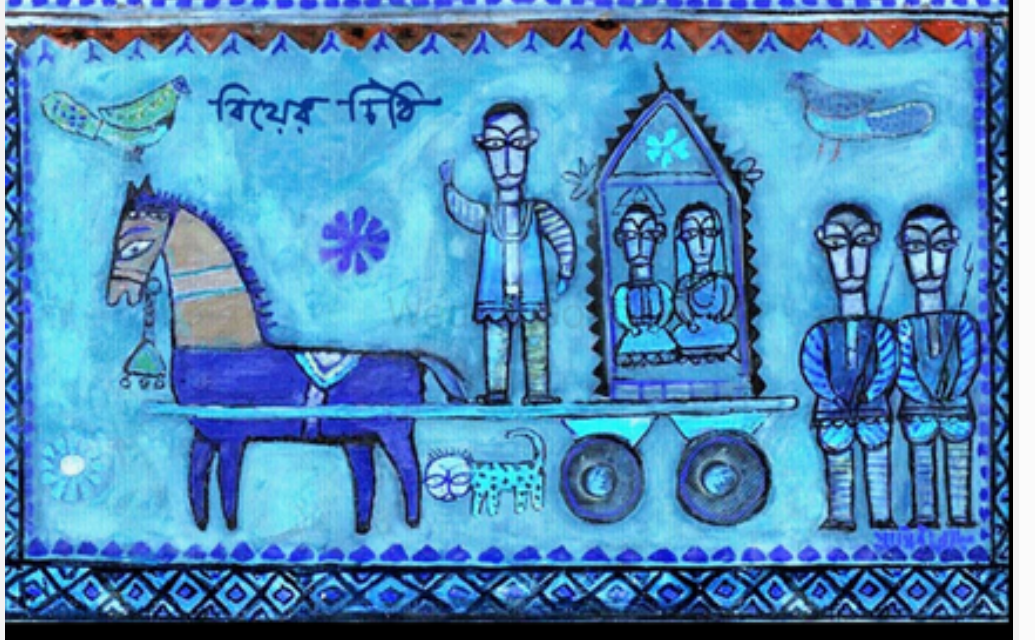

In [17]:
image_path = '/home/scar3crow/Downloads/biye.png'
x = cv2.imread(image_path)
x_pil = Image.fromarray(x[750:1390, 25:1060])
display(x_pil)

In [3]:
x.shape

(2160, 1080, 3)

In [27]:
## Draw box without sharpened image :

def draw_box(img_id, image_df, target_size):
    
    image_id = str(img_id) + '.jpg'
    image_path = '/home/scar3crow/Downloads/drg_all/' + image_id
    
    print(image_path)

# find index of image in data frame :

    image_list = r_new_data['img_id'].unique() # make a list of unique images
    idx = [i for i in range(len(image_list)) if image_list[i] == image_id] # find index of image

# reading image and resizing as per target image :
    print('====================', idx)

    x = cv2.imread(image_path)
    x_ratio = target_size[1] / x.shape[1]
    y_ratio = target_size[0] / x.shape[0]

    xx = cv2.resize(x, (target_size[1], target_size[0]))

# slicing as per current image id

    r_new_data_slice = r_new_data.loc[r_new_data['img_id'].isin([image_list[idx[0]]])].reset_index(drop=True) 

    m = int(target_size[1] / grid_size[1])  # making x-scale for making grid
    n = int(target_size[0] / grid_size[0])  # making x-scale for making grid

    x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14, m*15, m*16, m*17, m*18] 
    y_range = [0, n*1, n*2, n*3, n*4, n*5, n*6, n*7, n*8, n*9, n*10, n*11, n*12, n*13, n*14, n*15, n*16, n*17, n*18]
    
    for i in x_range:
            for j in y_range:
                cv2.rectangle(xx, (i, j), (i+32, j+32), 0, 2)
            
    for j in range(len(r_new_data_slice)):
        
        xmin = r_new_data_slice['x'][j]
        ymin = r_new_data_slice['y'][j]
    
        xxmin = int(r_new_data_slice['x'][j]*x_ratio)
        yymin = int(r_new_data_slice['y'][j]*y_ratio)
 
        xmax = (r_new_data_slice['x'][j] + r_new_data_slice['width'][j])
        ymax = (r_new_data_slice['y'][j] + r_new_data_slice['height'][j])
    
        xxmax = int((r_new_data_slice['x'][j] + r_new_data_slice['width'][j])*x_ratio)
        yymax = int((r_new_data_slice['y'][j] + r_new_data_slice['height'][j])*y_ratio)
        
        obj_class = r_new_data_slice['obj_class'][j]
    
#        print(xmin,ymin,xmax,ymax,xxmin,yymin,xxmax,yymax, obj_class)
        
        cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(x, obj_class, (xmin+10,ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    
        cv2.rectangle(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.putText(xx, obj_class, (xxmin+10,yymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
        cv2.line(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.line(xx, (xxmin, yymax), (xxmax, yymin), (255, 0, 0), 2)
        
    
    x_pil = Image.fromarray(x)
#    display(x_pil)

    xx_pil = Image.fromarray(xx)
#    display(xx_pil)

    return(display(x_pil), display(xx_pil))


/home/scar3crow/Downloads/drg_all/37.jpg
==================== [32]


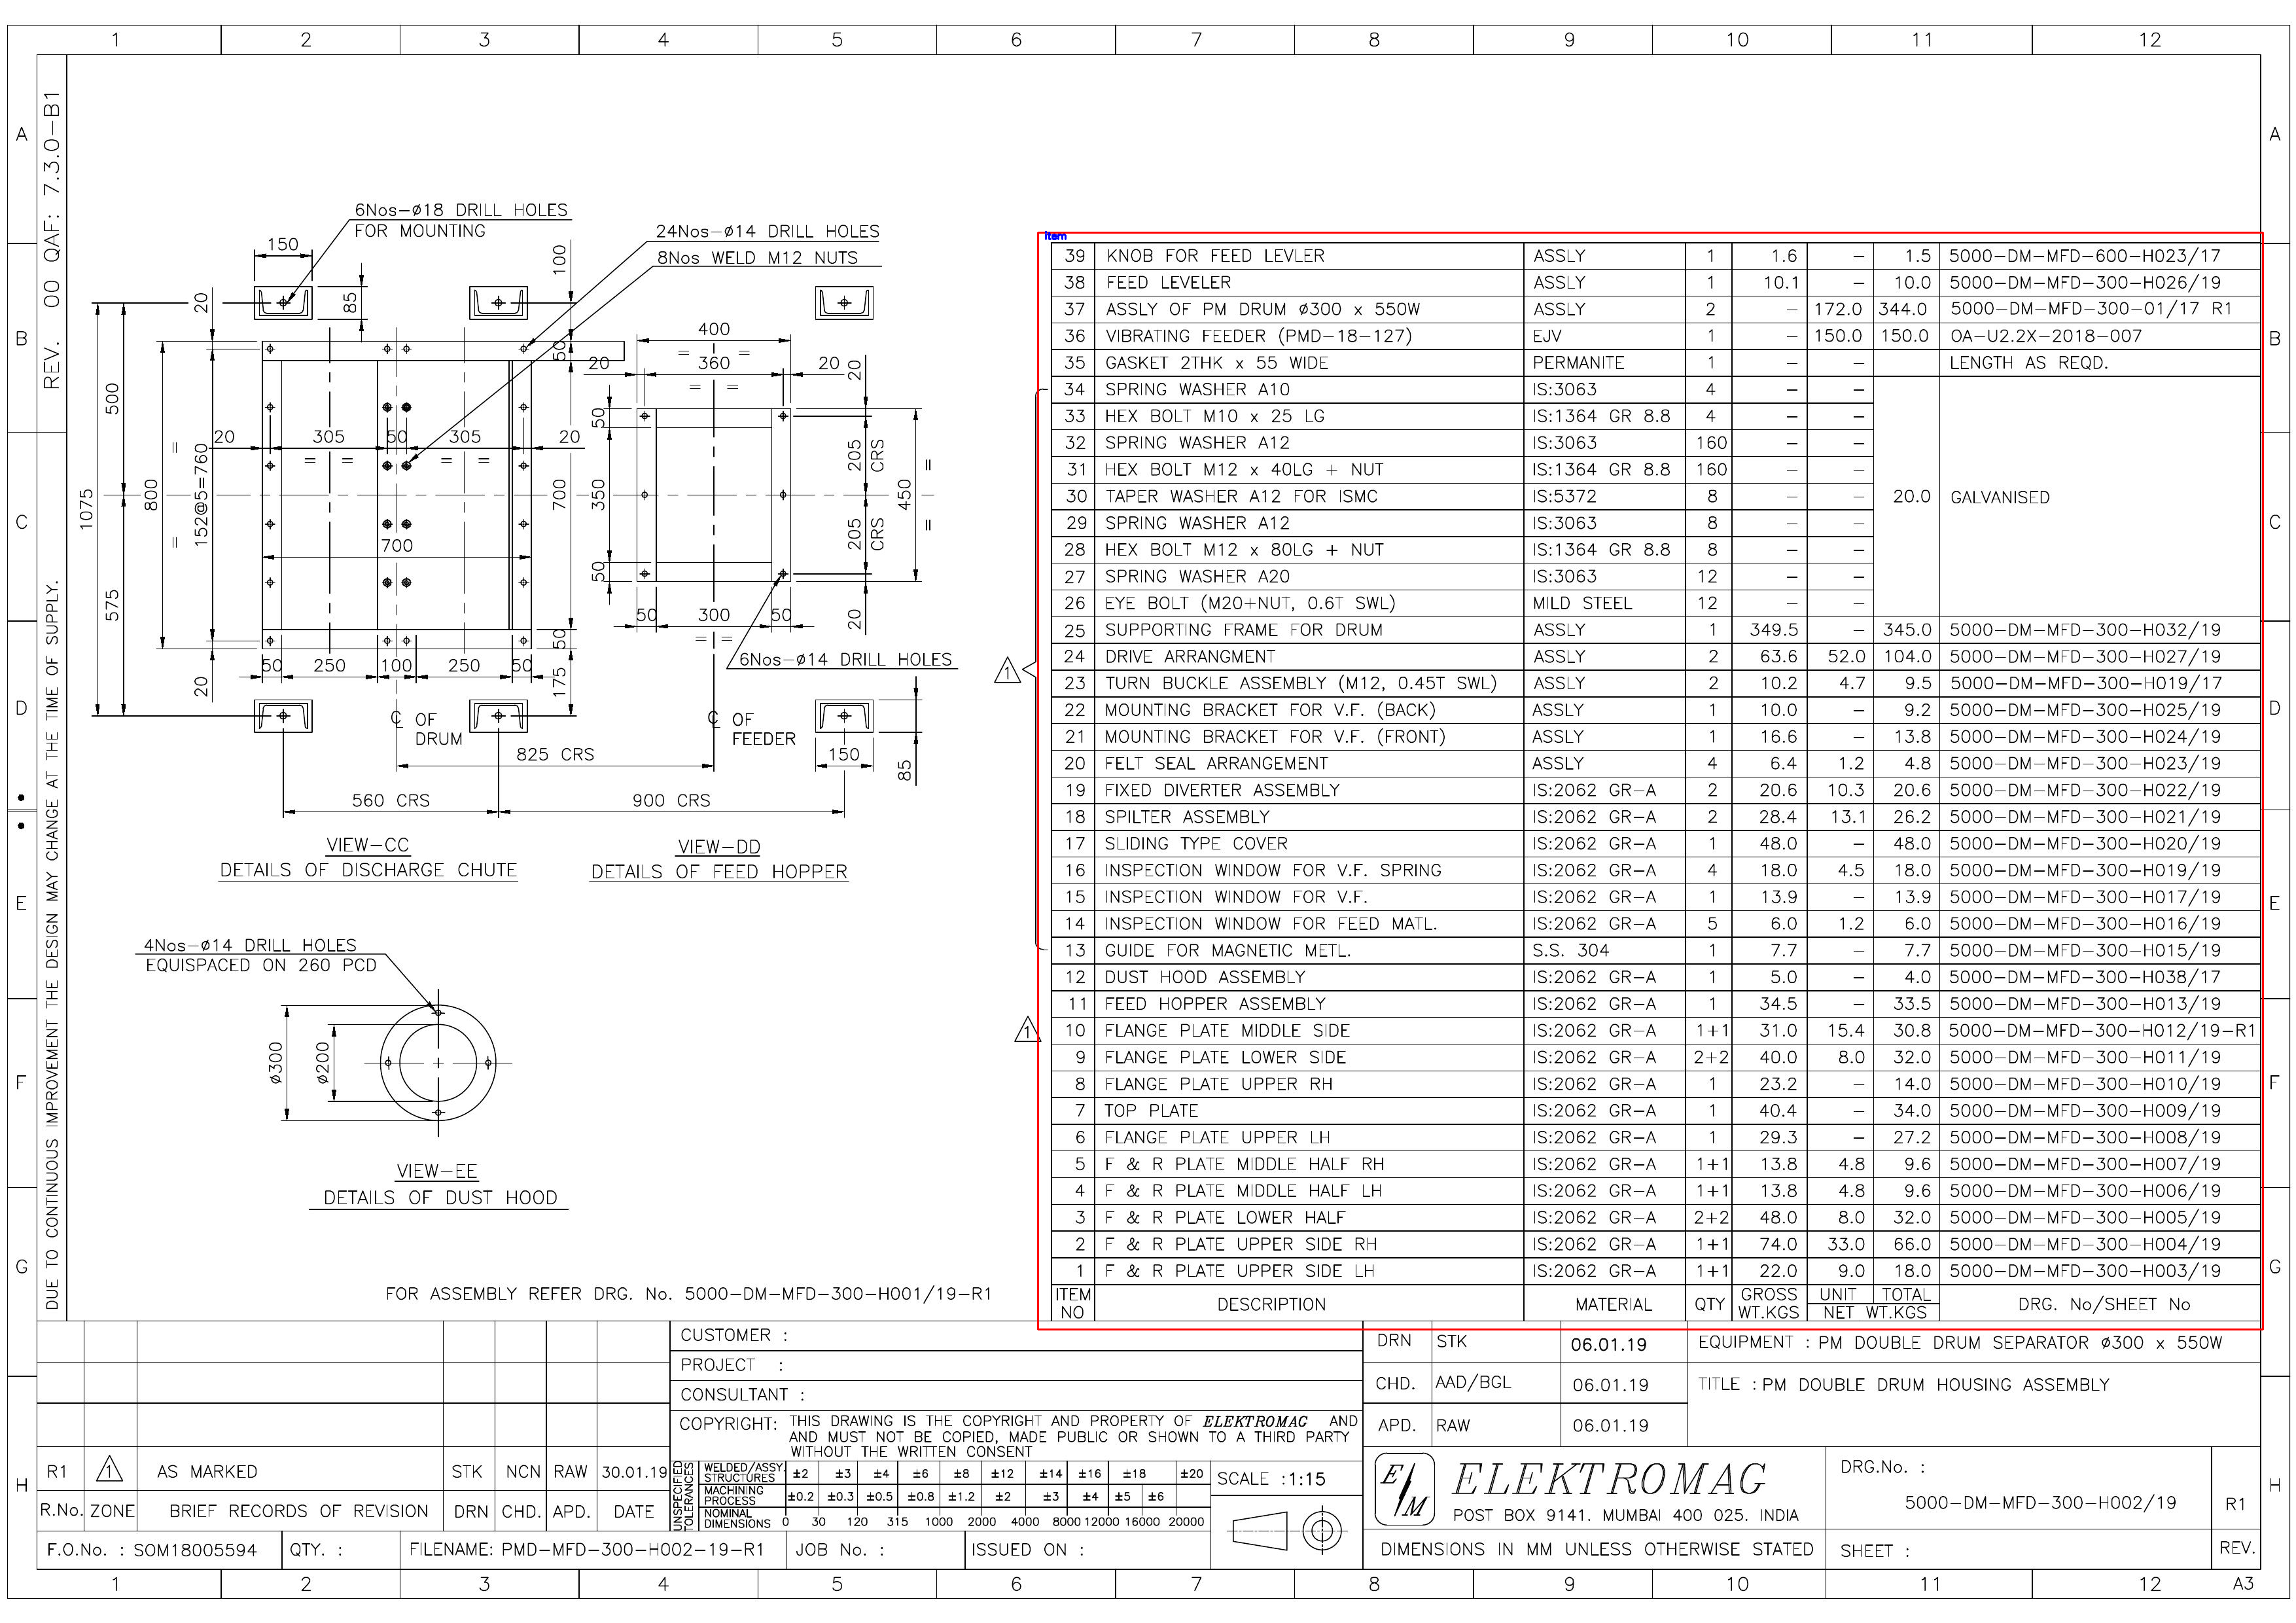

(None, None)

In [38]:
draw_box(37, r_new_data, target_size)

In [37]:
data_train[76]

[55,
 '/home/scar3crow/Downloads/drg_all/37.jpg',
 array([[1586.,  355., 3458., 2031.]], dtype=float32),
 array([0]),
 3509,
 2480]

In [41]:
Y_train[0, 9, 14]

array([[0.78192705, 0.5022186 , 0.41277084, 0.63412666, 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32)

In [48]:
# https://github.com/ethanyanjiali/deep-vision/blob/master/YOLO/tensorflow/utils.py

def xywh_to_x1y1x2y2(box):
    xy = box[..., 0:2]
    wh = box[..., 2:4]

    x1y1 = xy - wh / 2
    x2y2 = xy + wh / 2

    y_box = K.concatenate([x1y1, x2y2], axis=-1)
    return y_box

def broadcast_iou(box_a, box_b):
    """
    calculate iou between box_a and multiple box_b in a broadcast way
    inputs: box_a: a tensor full of boxes, eg. (B, N, 4), box is in x1y1x2y2
            box_b: another tensor full of boxes, eg. (B, M, 4)
    """

    # (B, N, 1, 4)
    box_a = tf.expand_dims(box_a, -2)
    # (B, 1, M, 4)
    box_b = tf.expand_dims(box_b, -3)
    # (B, N, M, 4)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_a), tf.shape(box_b))

    # (B, N, M, 4)
    # (B, N, M, 4)
    box_a = tf.broadcast_to(box_a, new_shape)
    box_b = tf.broadcast_to(box_b, new_shape)

    # (B, N, M, 1)
    al, at, ar, ab = tf.split(box_a, 4, -1)
    bl, bt, br, bb = tf.split(box_b, 4, -1)

    # (B, N, M, 1)
    left = tf.math.maximum(al, bl)
    right = tf.math.minimum(ar, br)
    top = tf.math.maximum(at, bt)
    bot = tf.math.minimum(ab, bb)

    # (B, N, M, 1)
    iw = tf.clip_by_value(right - left, 0, 1)
    ih = tf.clip_by_value(bot - top, 0, 1)
    i = iw * ih

    # (B, N, M, 1)
    area_a = (ar - al) * (ab - at)
    area_b = (br - bl) * (bb - bt)
    union = area_a + area_b - i

    # (B, N, M)
    iou = tf.squeeze(i / (union + 1e-7), axis=-1)

    return iou

## https://github.com/ethanyanjiali/deep-vision/blob/master/YOLO/tensorflow/yolov3.py#L213

def calc_ignore_mask(ignore_thresh, true_box, pred_box):
    
        # YOLOv3:
        # "If the bounding box prior is not the best but does overlap a ground
        # truth object by more than some threshold we ignore the prediction,
        # following [17]. We use the threshold of .5."
        # calculate the iou for each pair of pred bbox and true bbox, then find the best among them

        # (None, 13, 13, 3, 4)
        
        true_box_reorganised = xywh_to_x1y1x2y2(true_box)  # reorganised to x1, y1, x2, y2
        pred_box_reorganised = xywh_to_x1y1x2y2(pred_box)
        
        true_box_shape = tf.shape(true_box_reorganised)  
        # (None, 13, 13, 3, 4)
        pred_box_shape = tf.shape(pred_box_reorganised)  
        # (None, 507, 4)
        true_box_reorganised = tf.reshape(true_box_reorganised, [true_box_shape[0], -1, 4])
        # sort true_box to have non-zero boxes rank first
        true_box_reorganised = tf.sort(true_box_reorganised, axis=1, direction="DESCENDING")
        # (None, 100, 4)
        # only use maximum 100 boxes per groundtruth to calcualte IOU, otherwise
        # GPU emory comsumption would explode for a matrix like (16, 52*52*3, 52*52*3, 4)
        true_box_reorganised = true_box_reorganised[:, 0:100, :]
        # (None, 507, 4)
        pred_box_reorganised = tf.reshape(pred_box_reorganised, [pred_box_shape[0], -1, 4])

        # https://github.com/dmlc/gluon-cv/blob/06bb7ec2044cdf3f433721be9362ab84b02c5a90/gluoncv/model_zoo/yolo/yolo_target.py#L198
        # (None, 507, 507)
        iou = broadcast_iou(pred_box_reorganised, true_box_reorganised)
        # (None, 507)
        best_iou = tf.reduce_max(iou, axis=-1)
        # (None, 13, 13, 3)
        best_iou = tf.reshape(best_iou, [pred_box_shape[0], pred_box_shape[1], pred_box_shape[2], pred_box_shape[3]])
        # ignore_mask = 1 => don't ignore
        # ignore_mask = 0 => should ignore
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)
        # (None, 13, 13, 3, 1)
        ignore_mask = tf.expand_dims(ignore_mask, axis=-1)
        
        return ignore_mask

In [39]:
anchors = np.reshape(anchors_wrt_target, [1,1,1,3,2])

In [50]:
## made on 16/7/2020 at 8:48 pm

from functools import partial

# anchors = np.reshape(anchors_wrt_target, [1,1,1,3,2])

def my_custom_loss(y_true, y_pred):
    
    def pre_loss(my_custom_loss, anchors):
        
        num_anchors = len(anchors)
        num_classes = 1
        ignore_thresh = 0.5
        grid_size = [19., 19.]
        grid_stride = 608. / grid_size[0]
        batch_shape = y_pred.get_shape()
#        batch_size = batch_shape[0]
        batch_size = 8.
    
        scaled_anchors = anchors / grid_stride
    
        Lambda_Coord = 5.0
        Lambda_no_obj = 0.5
    
        grid_x = np.arange(grid_size[1])
        grid_y = np.arange(grid_size[0])
    
        a = np.array(np.meshgrid(grid_x, grid_y))
        b = np.array(np.meshgrid(grid_x, grid_y))
        c = np.array(np.meshgrid(grid_x, grid_y))
        d = np.concatenate((a,b,c), axis = 0)
        e = d.transpose(2, 1, 0)
        grid_final = np.reshape(e,[1,19,19,3,2])
        grid_final[..., [0,1]] = grid_final[..., [1,0]]
    
        tot_loss = tf.zeros(1, dtype='float32')

        obj_mask = y_true[..., 4:5]

## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

        pred_box_xy = K.sigmoid(y_pred[..., :2]) + grid_final  # this gives x & y in no. of cells. x & y w.r.t. target
                                                               # image = (x & y in no. of cells) / no. of cells
        pred_box_xy_wrt_target_image = (pred_box_xy * grid_stride) / 608.
        true_box_xy_wrt_target_image = y_true[..., :2]

        xy_arr = Lambda_Coord * K.square(true_box_xy_wrt_target_image - pred_box_xy_wrt_target_image)
    
        xy_loss = K.sum(xy_arr * obj_mask) / batch_size
    
## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
                       
        pred_box_wdht = K.exp(y_pred[..., 2:4]) * (anchors / 608.)
    
        true_box_wdht = y_true[..., 2:4]
    
        wh_arr = Lambda_Coord * K.square(true_box_wdht - pred_box_wdht)
    
        wh_loss = K.sum(wh_arr * obj_mask) / batch_size
    
## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
        
        pred_obj_mask = K.sigmoid(y_pred[..., 4:5])  # shape = 28, 17, 17, 3, 1
       
        true_box_wrt_ti = K.concatenate([true_box_xy_wrt_target_image, true_box_wdht], axis = -1)  ## in x,y,w,h format
        pred_box_wrt_ti = K.concatenate([pred_box_xy_wrt_target_image, pred_box_wdht], axis = -1)  ## in x,y,w,h format
    
        ignore_mask = calc_ignore_mask(ignore_thresh, true_box_wrt_ti, pred_box_wrt_ti)
        
#        bce = tf.keras.losses.BinaryCrossentropy()        
#        obj_loss = K.sum(bce(obj_mask, pred_obj_mask) * obj_mask)

        obj_loss_arr = K.square(obj_mask - pred_obj_mask)
        obj_loss = K.sum(obj_loss_arr * obj_mask) / batch_size
    
        no_obj_mask = 1. - obj_mask
                
        noobj_loss_arr = Lambda_no_obj * K.square(obj_mask - pred_obj_mask)
        noobj_loss = K.sum(noobj_loss_arr * no_obj_mask * ignore_mask) / batch_size
        
        
## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

        true_classes = y_true[..., 5:6]
    
        pred_classes = K.sigmoid(y_pred[..., 5:6])
        
#        cce = tf.keras.losses.CategoricalCrossentropy()
    
#        class_loss = K.sum(bce(true_classes, pred_classes) * obj_mask)

        class_loss_arr = K.square(true_classes - pred_classes)
        class_loss = K.sum(class_loss_arr * obj_mask) / batch_size
        
#        tot_loss = xy_loss + wh_loss + obj_loss + noobj_loss + class_loss

        tot_loss = xy_loss + wh_loss + obj_loss + noobj_loss + class_loss

        
        return tot_loss
    
    loss = pre_loss(my_custom_loss, anchors)
    
    return loss
    


In [43]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


In [44]:
# 5/8 dropout

def make_yolov3_model_drop():
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
    
    x = Dropout(0.2)(x)
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    x = Dropout(0.2)(x)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    x = Dropout(0.2)(x)
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    
    # Layer 62 => 65
##    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
##                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])


    x = Dropout(0.2)(x)
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    
     # Layer 66 => 74
##    for i in range(3):
##        x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
##                            {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    x = Dropout(0.2)(x)
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 75 => 79
##    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103}])

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter':  18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

#===============================================================================================================
#    # Layer 95 => 980
#    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
#    x = UpSampling2D(2)(x)
#    x = concatenate([x, skip_36])

#    # Layer 99 => 106
#    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
#                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

#    model = Model(input_image, [yolo_82, yolo_94, yolo_106])

    final = Reshape((grid_y_axis,grid_x_axis,num_anchors,info))(yolo_94)
    model = Model(input_image, final)
    return model


In [45]:
# 5/8 dropout
input_size = (target_w, target_h, 3)


my_model_1 = make_yolov3_model_drop()
my_model_2 = make_yolov3_model_drop()
my_model_3 = make_yolov3_model_drop()
my_model_4 = make_yolov3_model_drop()

print(my_model_1.summary())


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 608, 608, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 608, 608, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

In [46]:
# 5/8/20 dropout
epoch = 300
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4/epoch)

my_model_1.compile(optimizer= opt, loss = my_custom_loss, metrics = ['accuracy'])

In [51]:
5# 6/8/20 dropout
my_model_1.fit(X_train ,Y_train, epochs= 5, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/5


ValueError: in user code:

    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    <ipython-input-42-15688c837560>:93 pre_loss  *
        class_loss = K.sum(class_loss_arr * obj_mask) / batch_size
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py:1141 binary_op_wrapper
        raise e
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py:1457 _mul_dispatch
        return multiply(x, y, name=name)
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py:509 multiply
        return gen_math_ops.mul(x, y, name)
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py:6176 mul
        "Mul", x=x, y=y, name=name)
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 19 and 3 for '{{node my_custom_loss/mul_13}} = Mul[T=DT_FLOAT](my_custom_loss/Square_4, my_custom_loss/strided_slice)' with input shapes: [?,19,19,3], [?,19,19,3,1].


In [3]:
# 5/8 dropout

def make_yolov3_model_drop():
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
    
    x = Dropout(0.2)(x)
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    x = Dropout(0.2)(x)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    x = Dropout(0.2)(x)
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    
    # Layer 62 => 65
##    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
##                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])


    x = Dropout(0.2)(x)
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    
     # Layer 66 => 74
##    for i in range(3):
##        x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
##                            {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    x = Dropout(0.2)(x)
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 75 => 79
##    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103}])

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92}], skip=False)
    
    x = AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid")(yolo_94)
    
    yolo_last = _conv_block(x, [{'filter':  18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

#===============================================================================================================
#    # Layer 95 => 980
#    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
#    x = UpSampling2D(2)(x)
#    x = concatenate([x, skip_36])

#    # Layer 99 => 106
#    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
#                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

#    model = Model(input_image, [yolo_82, yolo_94, yolo_106])

####    final = Reshape((grid_y_axis,grid_x_axis,num_anchors,info))(yolo_94)
    model = Model(input_image, yolo_last)
    return model


In [5]:
input_size = (608, 608, 3)


my_model_1 = make_yolov3_model_drop()
my_model_2 = make_yolov3_model_drop()
my_model_3 = make_yolov3_model_drop()
my_model_4 = make_yolov3_model_drop()

print(my_model_1.summary())


NameError: name 'Input' is not defined